## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
%matplotlib inline


In [2]:
df = pd.read_csv('data\project_1_task_2.csv', sep=";")
df.head()

user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b

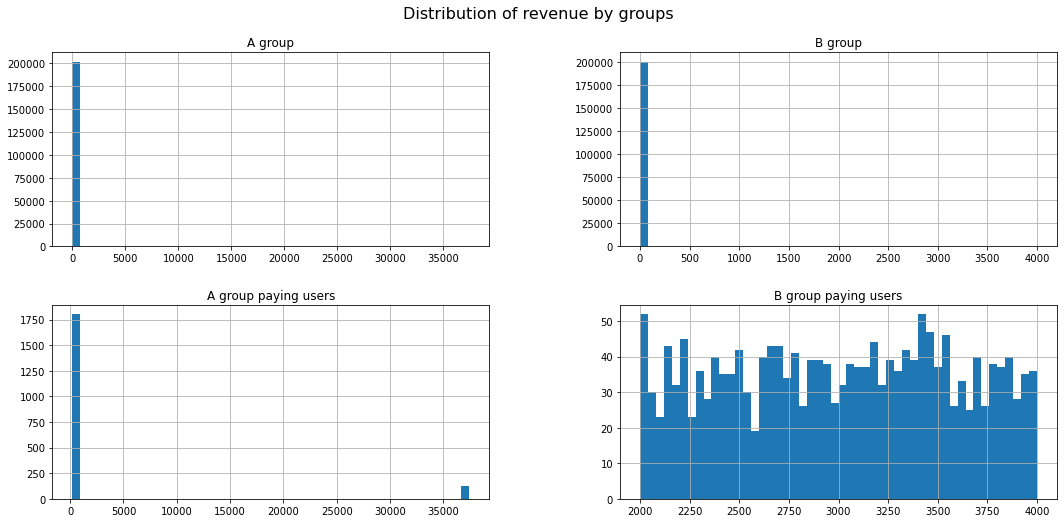

In [3]:
cols_to_plot = ['testgroup == "a"', 
                'testgroup == "b"', 
                'testgroup == "a" and revenue > 0', 
                'testgroup == "b" and revenue > 0']

fig, axes = plt.subplots(2, 2, figsize=(18, 8))

fig.suptitle('Distribution of revenue by groups', fontsize=16)
for ax, col, tit in zip(axes.flatten(), cols_to_plot, ['A group', 
                                                       'B group', 
                                                       'А group paying users', 
                                                       'B group paying users']):
    df.query(col).hist('revenue', ax=ax, bins=50)
    ax.set(xlabel='', ylabel='', title=tit)
plt.subplots_adjust(top=0.9)
plt.show()

Исходя из гистограмм мы видим, что в группе В распределение платящих пользователей равномерно исходя из сумм их оплат, в то время как в группе А, есть определенная градация, но пользователей которые платят сразу много и тех, кто оплачивает минимальные суммы. Более подробно посмотрим на платящих пользователей группы А.

In [4]:
group_A = df.query('testgroup == "a"')
group_B = df.query('testgroup == "b"')

In [5]:
group_A.query('revenue > 5000').revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [6]:
group_A.query('revenue > 0 and revenue < 5000').revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

Уже на данном этапе я бы предположил с группой А возможны некоторые ошибки в сборе информации и лишний раз это перепроверил, т.к. часть покупателей с огромными суммами выглядят как выбросы, а без них у нас получается равное количество платящих пользователей как в группе А, так и в группе B, но так как такой возможности у нас нету, предполагаем, что все сделано верно и двигаемся дальше.

Далее я решил проверить статистически ли значима разница в платящих пользователей у разных групп с помощью критерия хи-квадрат, создав bool-переменную оплатил пользователь или нет.

In [7]:
df['pay'] = df.revenue > 0

In [8]:
tab = pd.crosstab(df.pay, df.testgroup)
tab

testgroup       a       b
pay                      
False      200175  200862
True         1928    1805

In [9]:
stat, p, dof, expected = stats.chi2_contingency(tab)
p

0.03647561892312613

У нас получилось статистически значимое различие, что позволяет говорить, зависимость количества платящих пользователей действительно имеется.

Далее я проверил отличаются ли распределения выручки в группе А и группы В с помощью U-критерия Манна-Уитни (т.к. он не чувствителен к выбросам, которые мы можем наблюдать в группе А).

In [10]:
payable_A = df.query('testgroup == "a" and revenue > 0')
payable_B = df.query('testgroup == "b" and revenue > 0')
stats.mannwhitneyu(payable_B.revenue, 
                   payable_A.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Давайте посчитаем ARPPU для наших групп.

In [11]:
ARPPU_A = round(group_A.revenue.sum() / payable_A.shape[0])
print('ARPPU группы А:', ARPPU_A, 0)

ARPPU группы А: 2664 0


In [12]:
ARPPU_B = round(group_B.revenue.sum() / payable_B.shape[0])
print('ARPPU группы B:', ARPPU_B, 0)

ARPPU группы B: 3004 0


In [13]:
print('ARPPU группы B больше на: ', round((ARPPU_B / ARPPU_A) * 100 - 100, 2), '%', sep='')

ARPPU группы B больше на: 12.76%


Далее мы используем bootstrap для нахождения статистической значимости разности в ARPPU двух групп.
Здесь мы используем в качестве статистики медиану, ввиду наличия выбросов в группе А.

In [14]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, "p_value": p_value}

100%|██████████| 5000/5000 [00:01<00:00, 3881.46it/s]


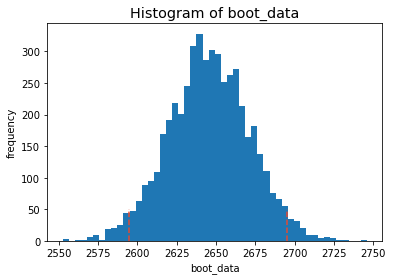

{'ci':             0
 0.025  2595.0
 0.975  2695.5,
 'p_value': 0.0}

In [15]:
get_bootstrap(payable_B.revenue, 
              payable_A.revenue, 
              boot_it=5000, 
              statistic=np.median, 
              bootstrap_conf_level=0.95)

Статистическая значимость различия подтвердилась, также мы видим, что медиана группы B, значительно превосходит медиану группы А

In [16]:
print('Выручка группы А формируется за счет пользователей с чеками более 30.000 на: ', 
      round(payable_A.query('revenue > 5000').revenue.sum() / group_A.revenue.sum() * 100, 2), 
      '%', sep='')

Выручка группы А формируется за счет пользователей с чеками более 30.000 на: 89.37%


In [17]:
print('Доля пользователей с чеками более 30.000 от обшего количества платящих пользователей в группе А составляет: ', 
      round(group_A.query('revenue > 5000').shape[0] / payable_A.shape[0] * 100, 2), 
      '%', sep='')

Доля пользователей с чеками более 30.000 от обшего количества платящих пользователей в группе А составляет: 6.38%


In [18]:
print('Суммарная выручка группы В больше суммарной выручки группы А на: ', 
      round(group_B.revenue.sum() / group_A.revenue.sum() * 100 - 100, 2), '%', sep='')

Суммарная выручка группы В больше суммарной выручки группы А на: 5.56%


#### Выводы:

Исходя из полученных данный мы можем говорить, что кол-во платящих пользователей в группе А больше на 6.8%, чем в группе B(естественно если дорогие плательщики в группе А не являются выбросами), но в тоже время ARPPU в группе B больше на 12,76% и мы подтвердили статистическую значимость этой разницы, что в конечном счете дает нам суммарную выручку группы В больше на 5,56%. К тому же доля дорогих пользователей группы А в размере 6,38% формируют 89,37% всей выручки группы, поэтому также с точки зрения безопаспности группа В лучше, т.к. волатильность группы А очень высока за счет такого распределения внутри группы.


### Соответственно выбор стоит остановить на группе В

## 3 задание
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Первичные метрики для анализа игрового события сроком на один месяц:

    MAU - проверяем общее количество уникальных пользователей за время данного события  
    ARPPU - проверяем выручку на каждого платящего игрока  
    Churn Rate - проверяем показатель оттока пользователей  
    Max Users Online - максимальное количество пользователей (хорошая метрика в особенности при наличи PvP режима, но мы не знаем есть ли здесь это)  
    Unit Sales - продажа предметов за премиальную валюту  




При увеличении сложности игровых механик (но если это gipercasual игра, то это заранее плохая идея), для анализа я бы добавил следующие метрики:  

    Churn by Level - отвал новых пользователей на уровне (супер важная метрика в данном ключе показывающая, насколько далеко доходят игроки с новым режимом)  
    Average Session Length - метрика показывающая как долго игрок находится в игровой сессии, а при наличии откатной механики, важно понять как изменилось это время игровой сессии  
    Total Daily Play Time - в целом за день, как долго играют в игру пользователи  
    Sessions per User - кол-во сессий на пользователя  

